In [1]:
from gboml import GbomlGraph

timehorizon = 17544

# Initialize and build the model
gboml_model = GbomlGraph(timehorizon=timehorizon)
nodes, edges, param = gboml_model.import_all_nodes_and_edges("../../models/wave/greenland_wave_test.gboml")
gboml_model.add_global_parameters(param)
gboml_model.add_nodes_in_model(*nodes)
gboml_model.add_hyperedges_in_model(*edges)
gboml_model.build_model()

# Solve the model
solution, obj, status, solver_info, constr_info, _ = gboml_model.solve_gurobi(opt_file="gurobi.txt", details=True)

print("Solved")


Check variables of node WAVE_PLANT_GR : --- 0.0 seconds ---
Check variables of node ENERGY_DEMAND_BE : --- 0.0 seconds ---
Check hyperlink DESTINATION_METHANE_BALANCE : --- 0.0 seconds ---
Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-03

Reading Gurobi options from file gurobi.opt
Set parameter Method to value 2
Set parameter BarHomogeneous to value 1
Set parameter Crossover to value 0

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 7735HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 192987 rows, 70179 columns and 385973 nonzeros
Model fingerprint: 0x57d9a105
Variable types: 52634 continuous, 17545 integer (17544 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+04]
  Objective range  [7e-03, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 1e+04]
Presolve removed 192987 

In [2]:
import json

gathered_data = gboml_model.turn_solution_to_dictionary(solver_info, status, solution, obj, constr_info)
print("Json done")
with open(f'../../models/wave/results/RREH.json', "w") as fp:json.dump(gathered_data, fp, indent=4)

Json done


In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class MakeMeReadable:
    def __init__(self, d):
        self.d = d
    
    def __dir__(self):
        return self.d.keys()
    
    def __getattr__(self, v):
        try:
            out = self.d[v]
            if isinstance(out, dict):
                return MakeMeReadable(out)
            return out
        except:
            return getattr(self.d, v)
        
    def __str__(self):
        return str(self.d)
    
    def __repr__(self):
        return repr(self.d)

In [5]:
dico = {}
with open('../../models/wave/results/RREH.json', 'r') as f:
    dico = json.load(f)
            
d = MakeMeReadable(dico)
    
if isinstance(dico, dict):
    print('The data is a dictionary')
else:
    print('The data is not a dictionary')

The data is a dictionary


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_wave_production_dynamics(wave_prod_gr, start_date='2015-01-01'):
    # Create date range for the dataset
    date_range = pd.date_range(start=start_date, periods=len(wave_prod_gr), freq='H')

    # Create DataFrame for wave production
    wave_prod_df_gr = pd.DataFrame(wave_prod_gr, index=date_range, columns=['Elec'])
   
    # Smooth the data with a rolling mean
    wave_prod_df_gr['Smoothed'] = wave_prod_df_gr['Elec'].rolling(window=24).mean()
   
    # Plotting
    plt.figure(figsize=(12, 4))
    plt.fill_between(wave_prod_df_gr.index, wave_prod_df_gr['Smoothed'], color='dodgerblue', alpha=0.5)
    plt.title('Wave Energy Production Dynamics (Greenland)', fontsize=14, loc='left')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
    plt.ylabel('GWh')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

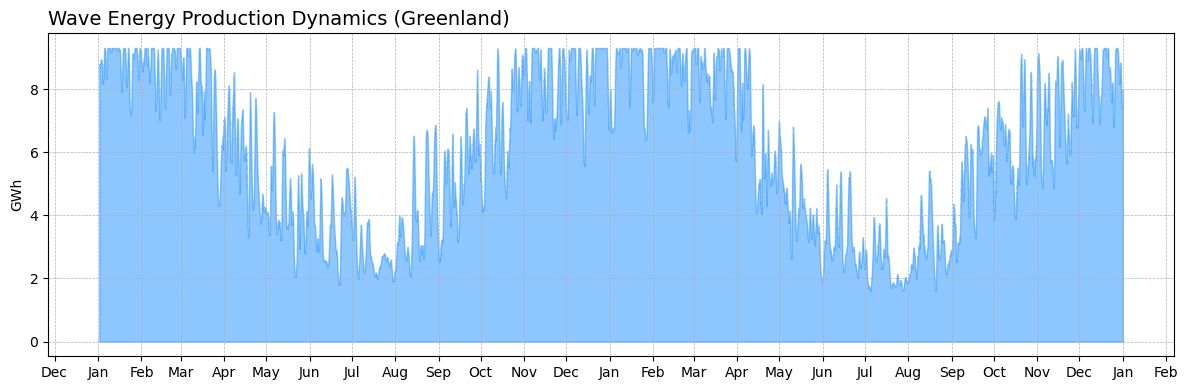

In [7]:
wave_prod_gr = np.array(d.solution.elements.WAVE_PLANT_GR.variables.electricity.values)

plot_wave_production_dynamics(wave_prod_gr)

In [8]:
wave_prod_gr

array([9.17361714, 9.2984    , 9.2984    , ..., 9.2984    , 9.2984    ,
       9.2984    ])

In [9]:
import pandas as pd

# Example input data
# If the CSV has no header row, set header=None and provide column names
column_name = ['WaveEnergyDensity']
wave_energy_df = pd.read_csv('../../data/wave_series_goff.csv', header=None, names=column_name)

length_of_installation = d.solution.elements.WAVE_PLANT_GR.variables.length.values[0]
unit_width = d.model.nodes.WAVE_PLANT_GR.parameters.unit_width[0]  # meters
space_between = d.model.nodes.WAVE_PLANT_GR.parameters.space_between[0]  # meters
wave_RP = d.model.nodes.WAVE_PLANT_GR.parameters.unit_rated_power[0]
wave_n_units = d.solution.elements.WAVE_PLANT_GR.variables.num_units.values[0]

# Calculate total space required per unit (width + space)
total_space_per_unit = unit_width + space_between

# Calculate the number of units that can be installed
number_of_units = length_of_installation // total_space_per_unit

# Calculate the total energy potential for each wave energy density value
wave_energy_df['TotalEnergyPotentialGW'] = wave_energy_df['WaveEnergyDensity'] * wave_n_units * unit_width

# Calculate the total rated energy capacity based on the number of units
total_rated_capacity_gw = wave_n_units * wave_RP

# Check when the total energy potential exceeds the total rated capacity
wave_energy_df['ExceedsRatedPower'] = wave_energy_df['TotalEnergyPotentialGW'] > total_rated_capacity_gw

print(wave_energy_df)

       WaveEnergyDensity  TotalEnergyPotentialGW  ExceedsRatedPower
0               0.000022                9.173617              False
1               0.000049               20.046684               True
2               0.000049               20.153152               True
3               0.000019                7.699438              False
4               0.000050               20.309157               True
...                  ...                     ...                ...
43817           0.000047               19.236732               True
43818           0.000027               11.031503               True
43819           0.000047               19.242526               True
43820           0.000047               19.241601               True
43821           0.000026               10.738111               True

[43822 rows x 3 columns]


In [10]:
demand = np.array(d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.demand[:timehorizon])

print(demand)

[0.07392996 0.07392996 0.07392996 ... 0.07392996 0.07392996 0.07392996]


C:\Users\gille\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


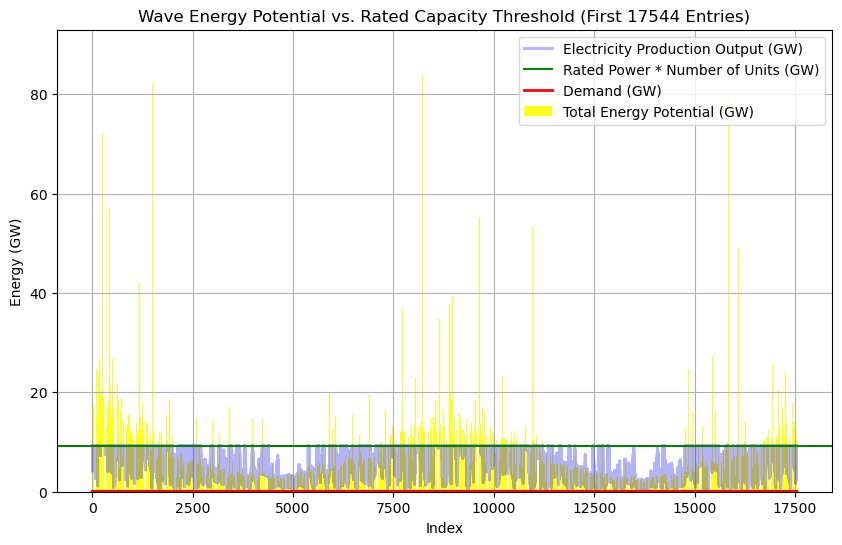

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Slice the DataFrame to only include the first x rows
wave_energy_df_subset = wave_energy_df.head(timehorizon)

# Convert wave_prod array/list to a pandas Series for easy plotting (match the length of the DataFrame subset)
wave_prod = pd.Series(wave_prod_gr[:timehorizon])

# Plotting
plt.figure(figsize=(10, 6))

# Plot Total Energy Potential GW for the subset as grey bars with 90% transparency
plt.bar(wave_energy_df_subset.index, wave_energy_df_subset['TotalEnergyPotentialGW'], color='yellow', alpha=0.9, label='Total Energy Potential (GW)')

# Plot the electricity production output as a grey line with 90% transparency
plt.plot(wave_energy_df_subset.index, wave_prod, color='blue', markersize=3, label='Electricity Production Output (GW)', alpha=0.3, linewidth=2)

# Plot a line for the Total Rated Capacity GW Threshold
plt.axhline(y=total_rated_capacity_gw, color='green', linestyle='-', label='Rated Power * Number of Units (GW)')

# Plot a line for the Demand
plt.plot(demand, color='red', label='Demand (GW)', linewidth=2)

# Set the y-axis limit to 10 times the total rated capacity
plt.ylim(0, 10 * total_rated_capacity_gw)

plt.xlabel('Index')
plt.ylabel('Energy (GW)')
plt.title('Wave Energy Potential vs. Rated Capacity Threshold (First {} Entries)'.format(timehorizon))
plt.legend()
plt.grid(True)

plt.show()

In [20]:

print(f'{wave_energy_df_subset["TotalEnergyPotentialGW"].max() = }')
print(f'{wave_energy_df_subset["TotalEnergyPotentialGW"].min() = }')

wave_energy_df_subset["TotalEnergyPotentialGW"].max() = 196.5940299648
wave_energy_df_subset["TotalEnergyPotentialGW"].min() = 0.0739469982992


In [13]:
n=0
x=0
g=0
for t in range(len(wave_energy_df_subset)):
    calculated_prod = min(wave_energy_df_subset['WaveEnergyDensity'][t] * wave_n_units * unit_width, wave_RP * wave_n_units)
    if calculated_prod < wave_prod[t]:
        if 1.1*calculated_prod< wave_prod[t]:
            n+=1
        print(f"Overprod at time {t}: Expected {round(calculated_prod,4)}, in Model {round(wave_prod[t],4)}")
    elif calculated_prod > wave_prod[t]: 
        x+=1
        print(f"Underprod at time {t}: Expected {round(calculated_prod,4)}, in Model {round(wave_prod[t],4)}")
    elif calculated_prod == wave_prod[t]:
        g+=1
        print(f"Exactprod at time {t}: Expected {round(calculated_prod,4)}, in Model {round(wave_prod[t],4)}")


Underprod at time 0: Expected 9.1736, in Model 9.1736
Underprod at time 1: Expected 9.2984, in Model 9.2984
Underprod at time 2: Expected 9.2984, in Model 9.2984
Overprod at time 3: Expected 7.6994, in Model 7.6994
Underprod at time 4: Expected 9.2984, in Model 9.2984
Underprod at time 5: Expected 9.2984, in Model 9.2984
Underprod at time 6: Expected 6.5869, in Model 6.5869
Underprod at time 7: Expected 9.2984, in Model 9.2984
Underprod at time 8: Expected 9.2984, in Model 9.2984
Overprod at time 9: Expected 4.1098, in Model 4.1098
Underprod at time 10: Expected 9.2984, in Model 9.2984
Underprod at time 11: Expected 9.2984, in Model 9.2984
Underprod at time 12: Expected 9.2984, in Model 9.2984
Underprod at time 13: Expected 9.2984, in Model 9.2984
Underprod at time 14: Expected 9.2984, in Model 9.2984
Exactprod at time 15: Expected 6.8789, in Model 6.8789
Underprod at time 16: Expected 9.2984, in Model 9.2984
Underprod at time 17: Expected 9.2984, in Model 9.2984
Underprod at time 18: 

Exactprod at time 5617: Expected 5.4851, in Model 5.4851
Exactprod at time 5618: Expected 5.4743, in Model 5.4743
Underprod at time 5619: Expected 9.2984, in Model 9.2984
Exactprod at time 5620: Expected 5.4438, in Model 5.4438
Overprod at time 5621: Expected 5.4244, in Model 5.4244
Underprod at time 5622: Expected 9.2984, in Model 9.2984
Exactprod at time 5623: Expected 5.3778, in Model 5.3778
Exactprod at time 5624: Expected 5.351, in Model 5.351
Underprod at time 5625: Expected 9.2984, in Model 9.2984
Exactprod at time 5626: Expected 5.2908, in Model 5.2908
Underprod at time 5627: Expected 5.2578, in Model 5.2578
Underprod at time 5628: Expected 9.2984, in Model 9.2984
Exactprod at time 5629: Expected 5.1866, in Model 5.1866
Exactprod at time 5630: Expected 5.1487, in Model 5.1487
Underprod at time 5631: Expected 9.2984, in Model 9.2984
Exactprod at time 5632: Expected 5.069, in Model 5.069
Exactprod at time 5633: Expected 5.0274, in Model 5.0274
Underprod at time 5634: Expected 9.2

Underprod at time 9822: Expected 9.2984, in Model 9.2984
Underprod at time 9823: Expected 9.2984, in Model 9.2984
Underprod at time 9824: Expected 9.2984, in Model 9.2984
Exactprod at time 9825: Expected 6.2429, in Model 6.2429
Underprod at time 9826: Expected 9.2984, in Model 9.2984
Underprod at time 9827: Expected 9.2984, in Model 9.2984
Underprod at time 9828: Expected 9.2984, in Model 9.2984
Underprod at time 9829: Expected 9.2984, in Model 9.2984
Underprod at time 9830: Expected 9.2984, in Model 9.2984
Underprod at time 9831: Expected 9.2984, in Model 9.2984
Underprod at time 9832: Expected 9.2984, in Model 9.2984
Underprod at time 9833: Expected 9.2984, in Model 9.2984
Underprod at time 9834: Expected 9.2984, in Model 9.2984
Underprod at time 9835: Expected 9.2984, in Model 9.2984
Underprod at time 9836: Expected 9.2984, in Model 9.2984
Exactprod at time 9837: Expected 3.9414, in Model 3.9414
Underprod at time 9838: Expected 9.2984, in Model 9.2984
Underprod at time 9839: Expecte

Exactprod at time 12797: Expected 3.4324, in Model 3.4324
Overprod at time 12798: Expected 1.6977, in Model 1.6977
Exactprod at time 12799: Expected 3.4442, in Model 3.4442
Underprod at time 12800: Expected 3.4496, in Model 3.4496
Overprod at time 12801: Expected 1.7319, in Model 1.7319
Exactprod at time 12802: Expected 3.4598, in Model 3.4598
Overprod at time 12803: Expected 3.4644, in Model 3.4644
Exactprod at time 12804: Expected 1.6276, in Model 1.6276
Overprod at time 12805: Expected 3.473, in Model 3.473
Exactprod at time 12806: Expected 3.4769, in Model 3.4769
Exactprod at time 12807: Expected 2.1138, in Model 2.1138
Exactprod at time 12808: Expected 3.484, in Model 3.484
Exactprod at time 12809: Expected 3.4872, in Model 3.4872
Overprod at time 12810: Expected 2.7226, in Model 2.7226
Underprod at time 12811: Expected 3.4928, in Model 3.4928
Underprod at time 12812: Expected 3.4953, in Model 3.4953
Underprod at time 12813: Expected 2.9161, in Model 2.9161
Overprod at time 12814:

Exactprod at time 15555: Expected 6.9409, in Model 6.9409
Exactprod at time 15556: Expected 5.63, in Model 5.63
Exactprod at time 15557: Expected 5.6312, in Model 5.6312
Underprod at time 15558: Expected 9.2984, in Model 9.2984
Overprod at time 15559: Expected 5.6342, in Model 5.6342
Exactprod at time 15560: Expected 5.636, in Model 5.636
Underprod at time 15561: Expected 9.2984, in Model 9.2984
Exactprod at time 15562: Expected 5.6403, in Model 5.6403
Exactprod at time 15563: Expected 5.6428, in Model 5.6428
Underprod at time 15564: Expected 9.2984, in Model 9.2984
Exactprod at time 15565: Expected 5.6486, in Model 5.6486
Overprod at time 15566: Expected 5.6519, in Model 5.6519
Underprod at time 15567: Expected 9.2984, in Model 9.2984
Exactprod at time 15568: Expected 5.6592, in Model 5.6592
Underprod at time 15569: Expected 5.6632, in Model 5.6632
Underprod at time 15570: Expected 9.2984, in Model 9.2984
Exactprod at time 15571: Expected 5.6722, in Model 5.6722
Overprod at time 15572

In [14]:
print(n)
print(x)
print(g)

0
8195
7183


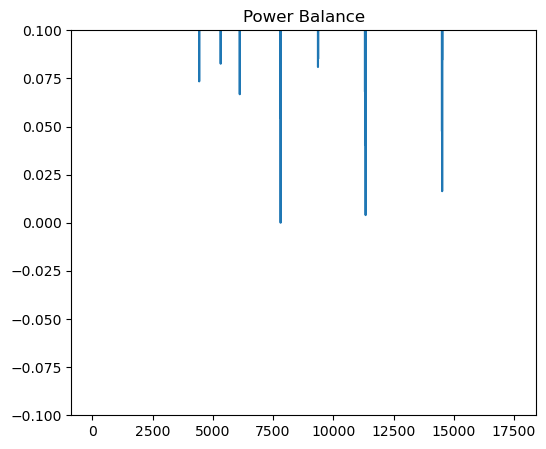

In [15]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Assuming 'd' is your data object with necessary attributes

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # Adjust figsize as needed

# Set the y-axis limit
ylim = (-0.1, 0.1)

def plot_balance(ax, data, title):
    ax.plot(data)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
# power balance
wave = np.array(d.solution.elements.WAVE_PLANT_GR.variables.electricity.values)
balance = wave - demand

plot_balance(ax, balance, 'Power Balance')

In [16]:
1701 * 0.07 * 1.07**30 /(1.07**30 -1)

137.0774723724001